In [1]:
from functions_py import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import pandas as pd 
# import cv2
import skimage as sk
import scipy.ndimage as nd
from array import array
from functions_MuonsNSAMP1 import *

# from ROOT import *

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

# def Gaussian2(x,m1,s1,g1,a1, m2, s2, g2, a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m1-g1)/s1)**2) + a2*np.exp(-1/2*((x-m2-g2)/s2)**2)

def Gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)


def EnergySpectrum(x, N):
    return N * np.sin(x)*np.cos(x)**3

Colormap = 'jet'

Welcome to JupyROOT 6.28/04


In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth": 3,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

Colormap = 'jet'

Filename: /home/bruce/Documents/Programas/images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_200.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 400)   float32   
  1                1 ImageHDU       164   (700, 400)   float32   
  2                1 ImageHDU       164   (700, 400)   float32   
  3                1 ImageHDU       164   (700, 400)   float32   
None
----------------


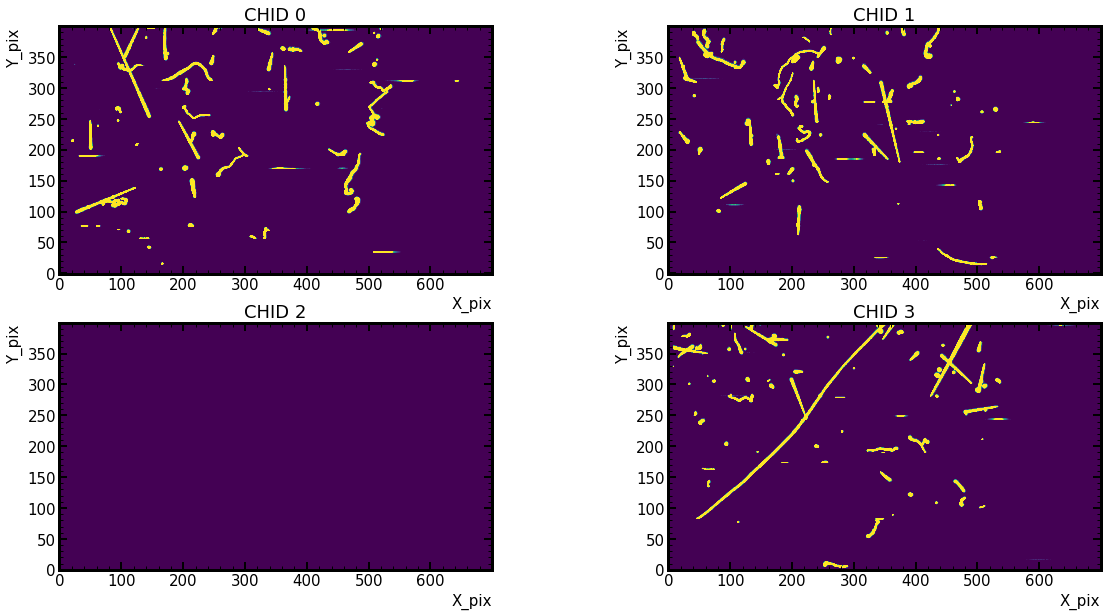

In [3]:
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_324_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/17OCT23/am241_gammas/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_50_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_690.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_225_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/05JUN2023/proc_skp_m_009_microchip_vtested_T_170_seq_NSAMP_144_NROW_100_NCOL.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_60_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_2.fits'
# path = '/home/labdet/Documents/MauSan/imagenesMicrochip/01NOV23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_32.fits'


## DIRECCIONES DE COMPUTADORA DE CASA 
# path = '/home/bruce/Documents/imagenesMicrochip/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_25.fits'


# path = '/home/bruce/Documents/imagenesMicrochip/ENE24/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_62.fits'
path = '/home/bruce/Documents/Programas/images/ENE2024/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_324_NROW_400_NCOL_700_EXPOSURE_0_NBINROW_1_NBINCOL_1_img_200.fits'

# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_100.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_101.fits'
# path = '/home/bruce/Documents/Programas/images/AGO2024/proc_skp_m-009_microchip_T_170__NSAMP_324_NROW_650_NCOL_700_EXPOSURE_0_img_102.fits'



hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=1000,vmax=10000, cmap = 'viridis')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

# Sustrayendo el promedio por renglón

## Sustrayendo la media del renglon

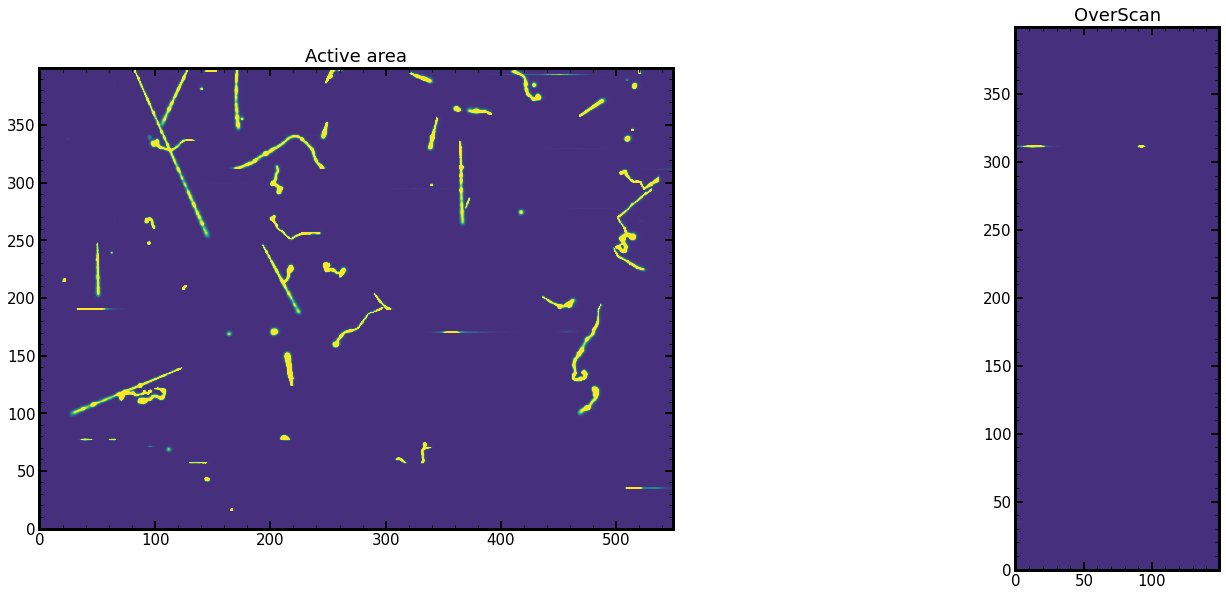

In [30]:
### Muestra el area activa y overscan de la extensión 

extension = 1
# plt.imshow(hdu_list[0].data[:, 550:], vmin = 0, vmax = 80000, origin = 'lower')
Overscan = hdu_list[extension - 1].data[:, 550:]
active_area = hdu_list[extension - 1].data[:, :550]


fig, axs = plt.subplots(1,2, figsize=[25,10])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
axs[0].imshow(active_area, origin='lower', vmin = 1000, vmax = 100000)
axs[0].set_title('Active area')

axs[1].imshow(Overscan, origin='lower', vmin = 1000, vmax = 100000)
axs[1].set_title('OverScan')

# plt.colorbar()
plt.show()

# fig, axs = plt.subplots(figsize=[10,10])
# active_area_mask=sk.measure.label(active_area>=np.max(active_area), connectivity=2)
# active_area_true=ma.masked_array(active_area,mask=(active_area_mask>0))
# plt.colorbar(location = 'bottom')
# plt.colorbar()

# fig.colorbar(x1, ax=axs[0])
# fig.colorbar(x2, ax=axs[1])

plt.show()


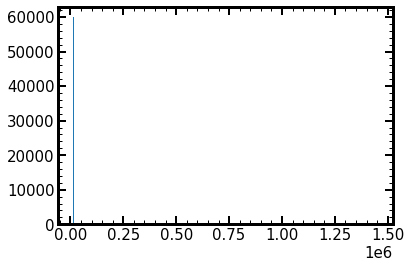

In [31]:
plt.hist(Overscan.flatten(), bins = 1000)
# plt.yscale('log')
plt.show()

In [32]:
### Dimensiones de Overscan
print('Dimensiones Oscan: ', Overscan.shape)
oscan_x = Overscan.shape[1]
oscan_y = Overscan.shape[0]


### Dimensiones de Active Area
print('Dimensiones ActA: ', active_area.shape)
acta_x = active_area.shape[1]
acta_y = active_area.shape[0]

Dimensiones Oscan:  (400, 150)
Dimensiones ActA:  (400, 550)


In [33]:
### Se sustrae la mediana de cada renglón y se crea un arreglo
mean_rows_value = []
for element in np.arange(0, oscan_y):
    row = Overscan[element: element +1, 0: oscan_x]
    num_row = element + 1
    # plt.imshow(row, origin='lower')
    # plt.show()
    # print(row.shape)
    # print(type(row))
    # print(row.sum()/row.shape[1])
    mean_value = np.median(row)
    mean_rows_value.append([mean_value])
    # print((num_row, mean_value))

print(mean_rows_value[0])

[14338.283]


In [34]:
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del area activa
true_active_area = active_area - mean_rows_value
print(active_area[1][1])
print(true_active_area[1][1])
### Se le resta el valor de promedio de cada renglón a su respectivo renglon del oScan
# true_Oscan = Overscan - mean_rows_value


true_Oscan = Overscan
min_oScan = np.min(true_Oscan)
# plt.imshow(true_active_area, origin='lower')

14341.546
-3.633789


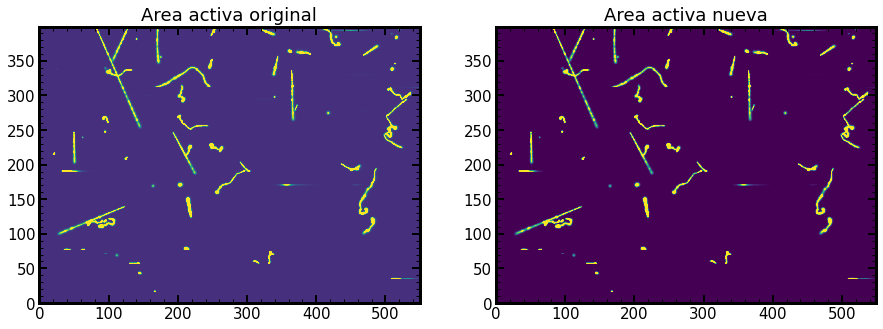

In [35]:
## Se muestra la comparación de la extensión original y despues de quitarle la mediana

Figsize = [15,15]
fig, axs = plt.subplots(1, 2, figsize=Figsize)
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Area activa original')
axs[1].set_title('Area activa nueva')
x0 = axs[0].imshow(active_area, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_active_area, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

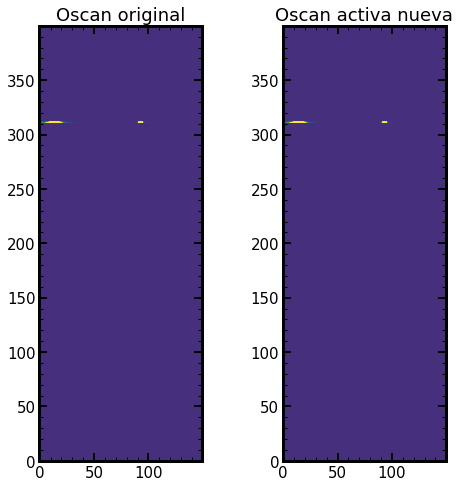

In [36]:
fig, axs = plt.subplots(1, 2, figsize=[8,8])
# oScan_mask=sk.measure.label(Overscan>=np.max(Overscan) , connectivity=2)
# oScan=ma.masked_array(Overscan,mask=(oScan_mask>0))
Vmin = 1000
Vmax = 100000
axs[0].set_title('Oscan original')
axs[1].set_title('Oscan activa nueva')
x0 = axs[0].imshow(Overscan, origin='lower', vmin=Vmin, vmax = Vmax)
x1 = axs[1].imshow(true_Oscan, origin='lower', vmin=Vmin, vmax = Vmax)
# plt.colorbar()

# fig.colorbar(x0, ax=axs[0]) 
# fig.colorbar(x1, ax=axs[1])

# print(active_area.max())
# print(true_active_area.max())
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


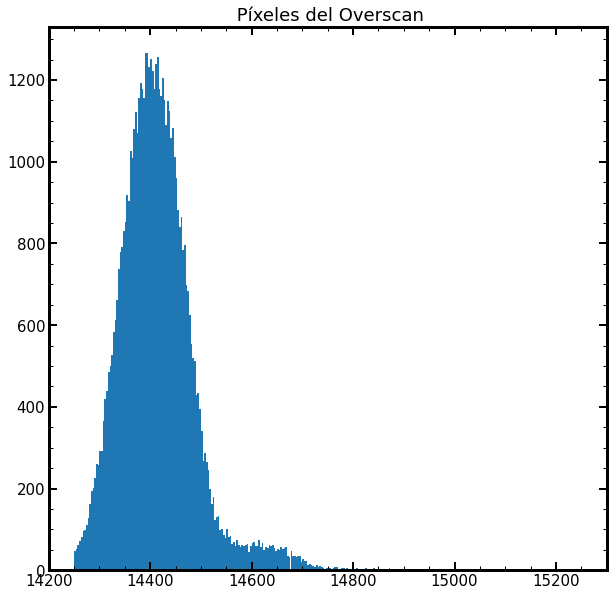

In [37]:
fig_all, axs_all = plt.subplots(1, 1, figsize=(10, 10))

min_oScan = np.min(true_Oscan)

## Generamos el histograma de los pixeles del oScan especificando el rango
bin_heights, bin_borders, _ = axs_all.hist(true_Oscan.flatten(), bins= 300, range = (14250, 15250))# , label="Pixeles del Overscan")
# axs_all.vlines(14651.275, ymin=0, ymax=900, colors='k', linestyle = 'dashed', label = 'Offset')
# axs_all.vlines(14720.0, ymin=0, ymax=2000, colors='r')

axs_all.set_title(' Píxeles del Overscan')
plt.legend()

plt.show()

## Aplanando el Oscan

Offset Value:  14392.564  ADUs
Parameters of the Doble-Gaussian Fit
Mean:  11.681914621844207  +-  0.26223204026772867
Sigma:  58.852293118332376  +-  0.18766529179465824
Gain:  221.32168116618675  +-  1.8005956726576047 

chiSquare: 1216.1634928464625
NDegrees of Freedom: 1105
chiSquare / NDF : 1.1006004460148981 

 FCN=1216.16 FROM MIGRAD    STATUS=CONVERGED     557 CALLS         558 TOTAL
                     EDM=7.17777e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.16819e+01   2.62232e-01   4.38399e-03   1.34858e-03
   2  p1           5.88523e+01   1.87665e-01   2.47904e-03   4.08838e-03
   3  p2           2.21322e+02   1.80060e+00   2.84087e-02   3.78363e-06
   4  p3           2.04311e+02   1.05617e+00   1.46997e-02  -4.75723e-04
   5  p4           8.12833e+00   2.15750e-01   3.28089e-03   3.12184e-03
 FCN=1216.16 FRO

Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


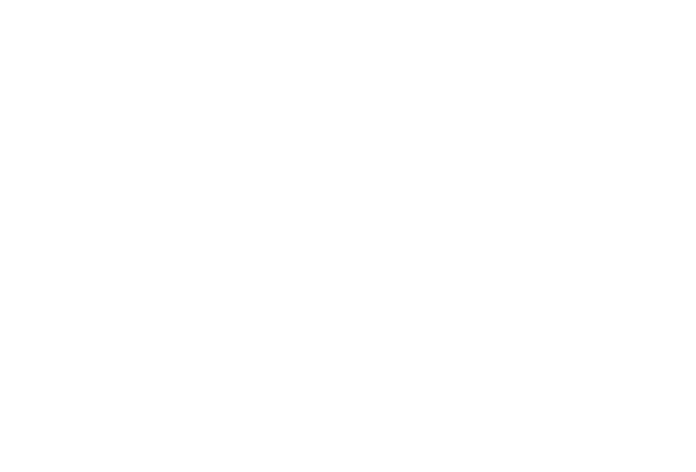

In [38]:
# min_oScan = np.min(true_Oscan)
# extension = 4
Bins = 500
ratio_keV = 0.0037  ## KeV/e-

# data = hdu_list[extension-1].data[:, :550]
data = true_active_area
header = hdu_list[extension-1].header
# oScan=hdu_list[extension-1].data[:,550:]

hist , bins_edges = np.histogram(true_Oscan.flatten(), bins = Bins,  range=(min_oScan, 18000))
offset = bins_edges[np.argmax(hist)]
print('Offset Value: ', offset, ' ADUs')
Overscan_plane = true_Oscan - offset 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-300,600,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of OsCan",1500,-300,500)
for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
    #print(pixel_value)
fgaus2.SetParameters(0,10,100, 100, 100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2)
c1=TCanvas()
h3.Draw()
c1.Draw()
fgaus2.Draw("same")
gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)
# # fgaus2.Draw('Quiet')
# print('Parameters of the Doble-Gaussian Fit')
# print('Mean: ', fgaus2.GetParameters()[0],  ' +- ', fgaus2.GetParError(0))
# print('Sigma: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
# print('Gain: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2), '\n')
# print("chiSquare: " + str(fgaus2.GetChisquare()))
# print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
# print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF(), '\n')


dict_popt =  oScan_fit_NSAMP324_ROOT(extensión = extension, active_area = data, oScan = true_Oscan, Bins = Bins, make_figure_flag = True)


In [39]:
##### Sigma en e- ####
sig_ADUs = dict_popt['sigma']
Gain = dict_popt['Gain']
offset = dict_popt['Offset']

sig_elec = abs(( sig_ADUs) / Gain)
print('Sigma: ', sig_elec, ' e-')

Sigma:  0.26591291376528614  e-


In [40]:
dataCal, sigma = data_calibrated_NSAMP(active_area = data, extension = extension, offset = offset, gain = Gain, ratio_keV = ratio_keV, unidades = 2, sigma_ADUs = sig_ADUs)
print('Sigma: ', sigma, ' keV')

Sigma:  0.0009838777809315588  keV


## Creacción del DataFrame de los clusters detectados

In [51]:
min_energy_for_label = 4 * sigma
label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
prop = sk.measure.regionprops(label_img, dataCal)

TotalDataFrame = event_DataFrame(dataCal=dataCal, label_img=label_img, nlabels_img =nlabels_img, 
                                    prop=prop, header=header, extension=extension, unidades = 2)

TotalDataFrame[0:20]

Events: 58


,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
1,200,1,2x2,4,32.735107,8.184,"[0.5, 0.5]"
2,200,1,35x1,35,174.998688,5.000,"[17.0, 0.0]"
3,200,1,5x4,17,65.697685,3.865,"[1.8824, 1.5882]"
4,200,1,16x1,16,86.366058,5.398,"[7.5, 0.0]"
5,200,1,11x5,26,58.689526,2.257,"[4.5769, 2.2308]"
6,200,1,9x18,55,261.182617,4.749,"[1.9818, 9.3818]"
7,200,1,5x4,16,6.397971,0.400,"[2.0, 1.5]"
8,200,1,4x1,4,1.143663,0.286,"[1.5, 0.0]"
9,200,1,11x1,11,84.249397,7.659,"[5.0, 0.0]"


[[False False  True False False]
 [False  True  True  True False]
 [ True  True  True  True  True]
 [False  True  True  True False]
 [False False  True False False]]


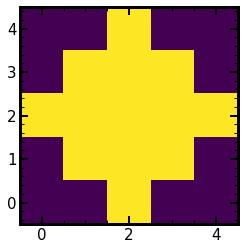

In [42]:
list_example = [[0,0,0,0,0], [0,0,0,0,0], [0,0, True,0,0], [0,0,0,0,0], [0,0,0,0,0]]
skirt = nd.binary_dilation(list_example, iterations=2)
print(skirt)

plt.imshow(skirt)

## Visualizar un cluster y su información

23
Event Slice:
x: [468,491]
y: [357,373]


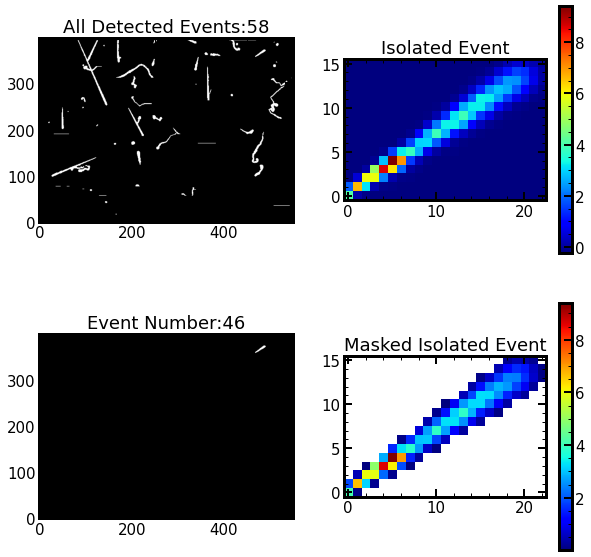

,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
46,200,1,23x16,97,189.07605,1.949,"[11.9691, 8.2474]"


In [48]:
n_label = 46
extra = 0


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[10,10])
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9)
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[1,0].set_title('Event Number:'+str(n_label))
axs[1,0].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[0,1].set_title('Isolated Event')
x1 = axs[0,1].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap= Colormap)#, origin = 'lower')
# plt.colorbar()

mask_35 = np.invert(label==n_label)


data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
print(len(data_mask[0]))

axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap= Colormap)#, origin='lower')
# axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[0,1])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()


TotalDataFrame.iloc[[n_label-1]]

### Con faldas

27
Event Slice:
x: [468,491]
y: [357,373]


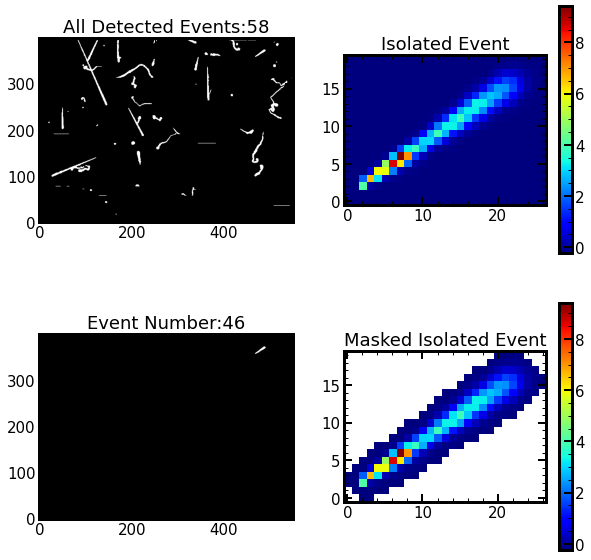

,Image ID,Extension,Matrix Size (px),Event Size (px),Total Charge (KeV),Mean Charge (KeV),Barycenter (px)
Event ID,,,,,,,
46,200,1,23x16,97,189.07605,1.949,"[11.9691, 8.2474]"


In [56]:
n_label = 46
n_skirts = 2
extra = 2


label, n_events = ndimage.label(dataCal > min_energy_for_label,structure=[[1,1,1],[1,1,1],[1,1,1]]) # 48
# label, n_events = ndimage.label(dataCal>6*abs(popt[2]),structure=[[0,1,0],[1,1,1],[0,1,0]]) ## 50, 52
loc = ndimage.find_objects(label==n_label)[0]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=[10,10])
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9)
# fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

# fig.suptitle('Event Number '+ str(n_label))
## Imagen original
axs[0,0].set_title('All Detected Events:'+str(n_events))
axs[0,0].imshow(label==0, cmap='gist_yarg', vmax=1, vmin=0, origin='lower')
# plt.suptitle('Primer Imagen')

## Evento en la imagen original
axs[1,0].set_title('Event Number:'+str(n_label))
axs[1,0].imshow(label==n_label, cmap='gray', vmax=1,vmin=0, origin='lower')


axs[0,1].set_title('Isolated Event')
x1 = axs[0,1].imshow(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], cmap= Colormap)#, origin = 'lower')
# plt.colorbar()

### Skirts ###
mask_35 = np.invert(nd.binary_dilation(label==n_label, iterations= n_skirts))
# mask_35 = np.invert(label==n_label)
# skirt = nd.binary_dilation(mask_35, structure=[[0,0,0],[0,1,0],[0,0,0]], iterations = 2)
# print(skirt)


data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])
print(len(data_mask[0]))

axs[1,1].set_title('Masked Isolated Event')
x2 = axs[1,1].imshow(data_mask, cmap= Colormap)#, origin='lower')
# axs[1,1].plot(totalFrame.iat[n_label-1, 7][0], totalFrame.iat[n_label-1, 7][1], 'ro') ## Plot the baricentrum
# print('n_label:', n_label)
# plt.legend('Baricentrum')

fig.colorbar(x1, ax=axs[0,1])
fig.colorbar(x2, ax=axs[1,1])
# fig.colorbar(axs[1,1], ax=[[x1,x2]], location = 'bottom', fraction = .1)

print('Event Slice:'  )
print('x: ['+str(loc[1].start)+','+str(loc[1].stop)+']')
print('y: ['+str(loc[0].start)+','+str(loc[0].stop)+']')
# print(loc)
# print(totalFrame.set_index('Event ID').iloc[[n_label-1]])
plt.show()


TotalDataFrame.iloc[[n_label-1]]

## Pruebas de la paquetería Sckit-Image

Centroide:  (42.588235294117645, 144.88235294117646)
Radio mayor:  5.181899763382574
Radio menor:  4.041201040002321
Box:  (41, 143, 45, 148)
Centroid Weighted:  (42.71309643370068, 144.95711361341444)
Label:  3
Orientation:  -1.3060015274038586
Slice:  (slice(41, 45, None), slice(143, 148, None))
Eccentricity:  0.625943231252129
Solidity:  1.0
Barycenter:  [1.58823529 1.88235294]


Event Charge:  65.697685  keV
Local Box:  [5, 4]  px
Local Box:  [75, 60] micras
Diagonal Lenght:  4.988910675059754  px
Diagonal Lenght:  74.8336601258963  micras
Delta_L:  725.0171647828234  px
Delta_L:  10875.257471742352  micras
Delta EL:  0.09061535151568273  keV/px
Delta EL:  0.006041023434378848  keV/micras
Delta EL:  906.1535151568272  keV/cm


(142.0, 149.0, 40.0, 46.0)

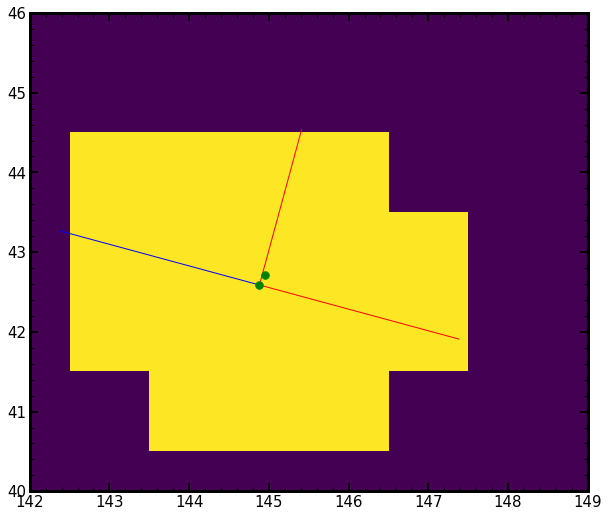

In [45]:
### Esta celda tiene el proceso para ir obteniendo las propiedadesd de un evento con la librería Scikit-Image

n_label= 3
CCD_depth = 725 ## micras
px_to_micras = 15 ## micras
px_to_cm = 0.0015 ## cm/px
micra_to_cm = 1 / 10000 ## micras/cm
fig, ax = plt.subplots(figsize=(10,10))

label_img, nlabels_img = sk.measure.label(dataCal > min_energy_for_label, connectivity=2, return_num=True)
# print(nlabels_img)
ax.imshow(label_img==n_label) # Matriz centrada en el origen

prop = sk.measure.regionprops(label_img,dataCal)
# prop = sk.measure.regionprops(label_img)

# loc = ndimage.find_objects(label==n_label)[0]
loc = prop[n_label-1].slice

mask_35 = np.invert(label_img==n_label)
# ax.imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
charge = data_mask.sum()
# plt.imshow(dataCal[maxim.start:maxim.stop])
# ax.imshow(data_mask)


print("Centroide: ", prop[n_label-1].centroid)
print("Radio mayor: ", prop[n_label-1].axis_major_length)
print("Radio menor: ", prop[n_label-1].axis_minor_length)
print("Box: ", prop[n_label-1].bbox)
# print("Centroide Local: ", prop[n_label-1].centroid_local)
print('Centroid Weighted: ', prop[n_label-1].centroid_weighted)
# print(prop[n_label-1].centroid_weighted_local)
# print(prop[n_label-1].coords_scaled)
# print(prop[n_label-1].coords)
# print(prop[n_label-1].extent)
# print(prop[n_label-1].image)
# print(prop[n_label-1].image_intensity)
print('Label: ', prop[n_label-1].label)
print('Orientation: ', prop[n_label-1].orientation)
print('Slice: ', prop[n_label-1].slice)
print('Eccentricity: ', prop[n_label-1].eccentricity)
print('Solidity: ', prop[n_label-1].solidity)
print('Barycenter: ', prop[n_label-1].centroid_local)
# print('Inertia tensor: ', prop[n_label-1].inertia_tensor)
# print('Intensity Max: ', prop[n_label-1].intensity_max)

print('\n')
## Ellipse 
y0, x0 = prop[n_label-1].centroid
# y0, x0 = prop[n_label-1].centroid_weighted

orientation = prop[n_label-1].orientation
rotation = orientation*1
x1 = x0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_minor_length
y1 = y0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_minor_length

x2 = x0 - math.sin(orientation) * 0.5 * prop[n_label-1].axis_major_length
y2 = y0 - math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio

x3 = x0 - math.sin(-orientation) * 0.5 * prop[n_label-1].axis_major_length
y3 = y0 + math.cos(orientation) * 0.5 * prop[n_label-1].axis_major_length # Ellipse's major radio


ax.plot((x0, x1), (y0, y1), 'r', linewidth=1)
ax.plot((x0, x3), (y0, y3), 'b', linewidth=1)
ax.plot((x0, x2), (y0, y2), 'r', linewidth=1)

ax.plot(x0, y0, '.g', markersize=15) # Ellipse's center
ax.plot(prop[n_label-1].centroid_weighted[1], prop[n_label-1].centroid_weighted[0], '.g', markersize=15)

## Box and Delta_L
miny, minx, maxy, maxx = prop[n_label-1].bbox
Longitud_y = maxy - miny # px
Longitud_x = maxx - minx # px
Diagonal_lenght= np.sqrt(Longitud_x**2 + Longitud_y**2) - np.sqrt(2) # px
Delta_L = np.sqrt(Diagonal_lenght**2 + CCD_depth**2) # px
DeltaEL = charge / Delta_L # keV/px

print('Event Charge: ', charge, ' keV')
print("Local Box: ", [Longitud_x, Longitud_y], ' px' )
print("Local Box: ", [Longitud_x * px_to_micras, Longitud_y * px_to_micras], 'micras' )
print('Diagonal Lenght: ', Diagonal_lenght, ' px') ## px
print('Diagonal Lenght: ', Diagonal_lenght * px_to_micras, ' micras')
print('Delta_L: ', Delta_L, ' px')
print('Delta_L: ', Delta_L * px_to_micras, ' micras')
print('Delta EL: ', DeltaEL, ' keV/px')
print('Delta EL: ', DeltaEL / px_to_micras, ' keV/micras')
print('Delta EL: ', DeltaEL / micra_to_cm, ' keV/cm')
bx = (minx, maxx, maxx, minx, minx)
by = (miny, miny, maxy, maxy, miny)
# ax.plot(bx, by, '-b', linewidth=2.5)


# excent = prop[n_label-1].eccentricity
u= x0   #x-position of the center
v= y0    #y-position of the center
b = prop[n_label-1].axis_major_length    #radius on the x-axis
a = prop[n_label-1].axis_minor_length   #radius on the y-axis

ext=1
ax.axis((loc[1].start-ext, loc[1].stop+ext, loc[0].start-ext, loc[0].stop+ext))
# ax.imshow(data_mask)
# ax.can_zoom()

## Filtro de muones 

In [46]:
## Calcula cuantos eventos rectos tiene la extensión comparando la relación del radio mayor de la elipse con el radio menor
DeltaL, DeltaEL, list_charge, lebel_muons, list_theta, _ = muon_filter(dataCal=dataCal, label_img=label_img, nlabels_img=nlabels_img, prop=prop, Solidit=0.6, Elipticity=0.6)
                                                                    
print('All Clusters: ', nlabels_img)
print('Muons Detected: ', len(lebel_muons))
print(lebel_muons)
Straight_Events = lebel_muons


DF_straightevents = pd.DataFrame(lebel_muons, columns=['Event ID'] )
DF_dl = pd.DataFrame(DeltaL, columns=['Delta L (cm)'])
DF_charge = pd.DataFrame(list_charge, columns=['Charge (e-)'])
DF_dedl = pd.DataFrame(DeltaEL, columns=['dE/dL (e-/cm)'])
DF_angle = pd.DataFrame(list_theta, columns=['Theta (°)'])
DF_dEdL = pd.concat([DF_straightevents, DF_dl, DF_charge,  DF_dedl, DF_angle], axis=1)
DF_dEdL.set_index('Event ID')

All Clusters:  58
Muons Detected:  9
[15, 24, 34, 41, 43, 46, 47, 54, 56]


,Delta L (cm),Charge (e-),dE/dL (e-/cm),Theta (°)
Event ID,,,,
15,0.085257,927.318604,10876.805196,31.747541
24,0.099932,205.659058,2057.984710,43.490253
34,0.130250,368.657654,2830.376635,56.177616
41,0.085496,217.607544,2545.247366,32.005579
43,0.076393,232.508896,3043.597428,18.369764
46,0.082757,189.076050,2284.717941,28.829270
47,0.079282,194.054047,2447.644380,23.871169
54,0.079015,200.222702,2533.967764,23.430711
56,0.073020,37.699829,516.297546,6.839138


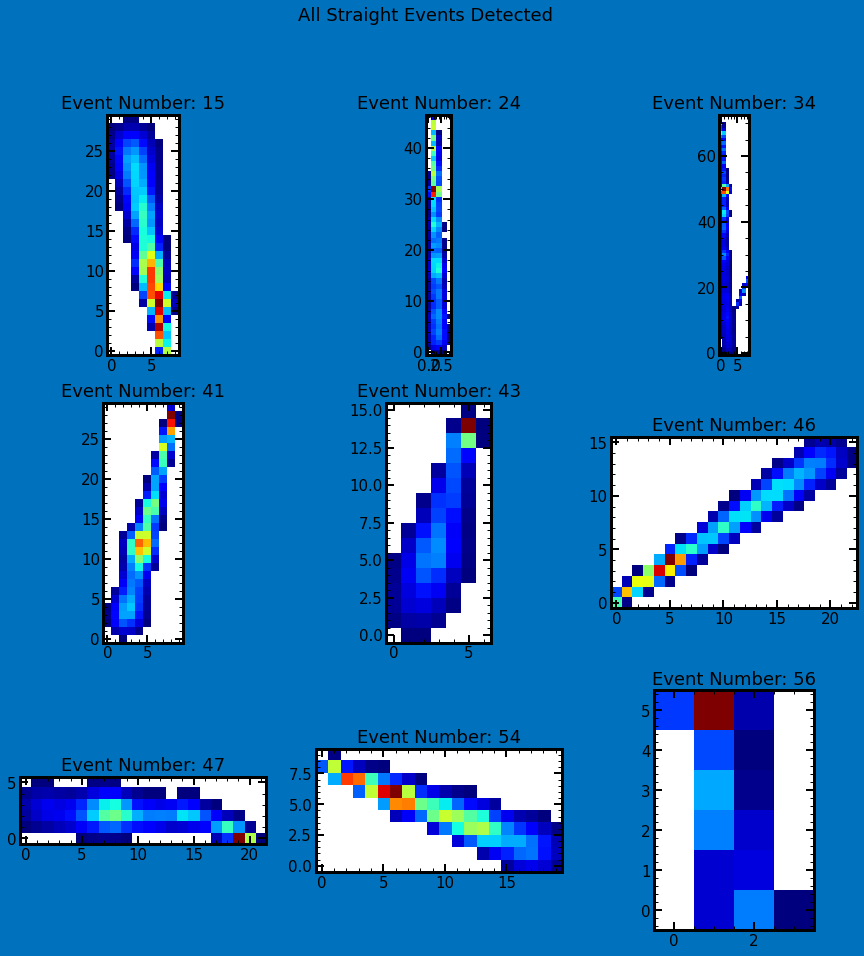

In [53]:
## Visualizar en una matriz los eventos rectos detectados 
coord2x2 = [[0,0],[0,1], [1,0], [1,1]]

coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]

coord4x4 = [[0,0],[0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [1,3], [2,0], [2,1], [2,2], [2,3], [3,0], [3,1], [3,2], [3,3]]

coords5x5 = [[0,0],[0,1], [0,2], [0,3], [0,4], [1,0], [1,1], [1,2], [1,3], [1,4], [2,0], [2,1], [2,2], [2,3], [2,4], [3,0], [3,1], [3,2], [3,3], [3,4],[4,0], [4,1], [4,2], [4,3], [4,4]]

if len(Straight_Events) < 5:
    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(15,15))
    fig.suptitle('All Muons Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord2x2[index_event][0],coord2x2[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord2x2[index_event][0],coord2x2[index_event][1]].imshow(data_mask) ## Event with mask
        # axs[coord2x2[index_event][0],coord2x2[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_

elif len(Straight_Events) > 4 and len(Straight_Events) < 10:
    fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)

        axs[coord3x3[index_event][0],coord3x3[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord3x3[index_event][0],coord3x3[index_event][1]].imshow(data_mask, aspect = 1,  cmap= Colormap) ## Event with mask
        # axs[coord3x3[index_event][0],coord3x3[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_event, 7][1], 'ro') ## Plot the baricentrum

elif len(Straight_Events) > 9 and len(Straight_Events) < 17:
    fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

        # coordX_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[1])
        # coordY_centerCharge = round(ndimage.center_of_mass(data_maskEvent)[0])
        # Barycentercharge = data_maskEvent[coordY_centerCharge, coordX_centerCharge]

        axs[coord4x4[index_event][0],coord4x4[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(label_img == Straight_Events[index_event]) ## All image
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coord4x4[index_event][0],coord4x4[index_event][1]].imshow(data_mask, aspect = 1) ## Event with mask
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].plot(TF.iat[Straight_Events[index_event]-1, 9][0], TF.iat[Straight_Events[index_event]-1, 9][1],  'ro')#[0], TF.iat[index_
        # axs[coord4x4[index_event][0],coord4x4[index_event][1]].text(1,0,'dE/dx', transform = axs[coord4x4[index_event][0],coord4x4[index_event][1]].transAxes)

elif len(Straight_Events) > 16 and len(Straight_Events) < 25:
    fig, axs = plt.subplots(ncols = 5, nrows = 5, figsize=(15,15), facecolor = [0, 0.4470, 0.7410])
    fig.suptitle('All Straight Events Detected')

    for index_event in range(0,len(Straight_Events)):
        loc = ndimage.find_objects(label_img == Straight_Events[index_event])[0]
        mask_35 = np.invert(label_img == Straight_Events[index_event])
        data_mask = ma.masked_array(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        # plt.imshow(dataCal[maxim.start:maxim.stop])
        # ax.imshow(data_mask)        

        axs[coords5x5[index_event][0],coords5x5[index_event][1]].set_title('Event Number: '+ str(Straight_Events[index_event]))
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(label_img == Straight_Events[index_event])
        # axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(dataCal[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop]) ## Event without mask
        axs[coords5x5[index_event][0],coords5x5[index_event][1]].imshow(data_mask, aspect = 1) ## Event with mask

elif len(Straight_Events) > 25:
    print('Demasiados eventos para mostrar!!!')



## Filtro de Muones Rectos

In [25]:
list_vertical, list_horizontal = muon_straight_filter(dataCal=dataCal, label_img=label_img, n_events=n_events, Solidit=0.7, Elipticity=0.7, 
                                                        Prop=prop, min_Charge=100, Sigma=sigma, skirts = 1)
# print(list_vertical[1])
print('Eventos Verticales encontrados: ', len(list_vertical[1]))
print('Eventos Verticales encontrados: ', len(list_horizontal[1]))
# plt.imshow(list_vertical[1][0])


Eventos Verticales encontrados:  3
Eventos Verticales encontrados:  0


Charge:  141.36455


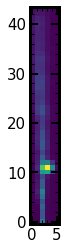

In [23]:
index = 0
plt.imshow(list_vertical[1][index])
print('Charge: ', list_vertical[2][index])


# plt.imshow(list_horizontal[1][0])
# print('Charge: ', list_horizontal[2][0])

## Perfil de Energía de un muon vertical

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1418.5356 318.92035


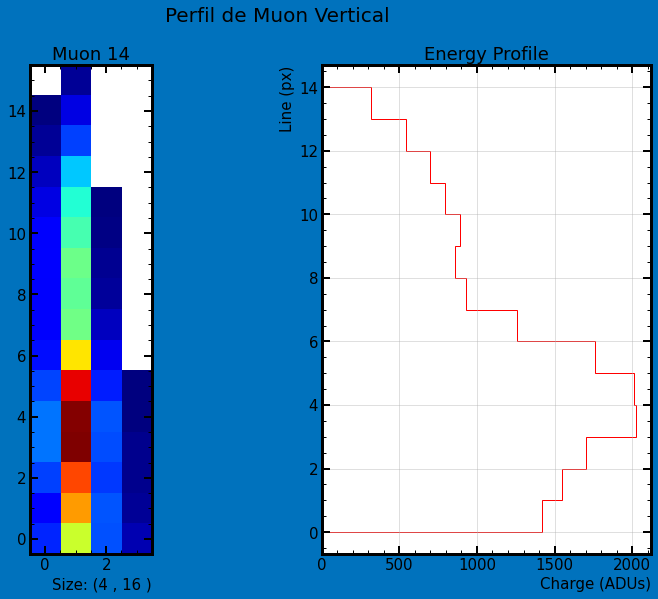

In [29]:
## Muons Extention 4
# muons_vertical_labels_1 = [[73], [3], [6], [14], [27]] #, 23,  27, 40, 43, 46, 49, 59, 85, 92, 94, 98] # Extensión 4

muon_label = 14  # Se coloca directamente el label del evento

Delta_inicial = 1
Delta_final = 1
# extension = 4

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

# for event in matrix_ext_4_vertical[num:num + 1]:

# event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)
loc = ndimage.find_objects(label==muon_label)[0]
mask_35 = np.invert(label==n_label)
data_mask = ma.masked_array(dataCal[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra], mask_35[loc[0].start-extra:loc[0].stop+extra, loc[1].start-extra:loc[1].stop+extra])

muon_recto = data_mask
# print(muon_recto)


event = data_mask
# plt.imshow(event)
size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

charge_verticalMuon = []
for lable_line in np.arange(Delta_inicial, nlabels_verticalMuon - Delta_final):
    line = label_verticalMuon == lable_line
    loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    mask_35 = np.invert(label_verticalMuon == lable_line)
    data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    # print(len(data_mask[0]))
    charge = data_mask.sum()
    # print(charge)
    mean_charge = data_mask.mean()

    charge_verticalMuon.append(charge)
    # print(charge)

## Linea inferior ##
# line_inf = [size_x]
# axs[0].imshow(data_mask)
print(charge_verticalMuon[0], charge_verticalMuon[-1])
        
# cmap = 'plasma'
axs[0].imshow(event, cmap = 'jet', origin='lower')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs[1].set_xlabel('Charge (ADUs)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

## Modelo de Difusión 

16
True


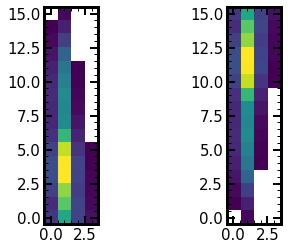

In [31]:
Delta_inicial = 1    # px
Delta_final = 1     # px


event = muon_recto
# plt.imshow(event)

label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])
print(nlabels_verticalMuon)
### Parte de abajo de la imagen ##
line = label_verticalMuon == Delta_inicial
# print(Delta_inicial)

loc = ndimage.find_objects(label_verticalMuon == Delta_inicial)[0]
mask_35 = np.invert(label_verticalMuon == Delta_inicial)
data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

Longitud_linea = len(data_mask[0])
Carga_renglon = data_mask[0].sum()
Mean_carga = np.mean(data_mask[0])

Mean_in_1 = 0
var_1 = 0
carga_cuadrada = 0
NaN_pixel_1 = 0

for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
        Mean_in_1 = Mean_in_1 + element_pixel
    else:
        element_pixel = 0
    
    Mean_in_1 = Mean_in_1 + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = data_mask[0][pixel]**2
    else:
        NaN_pixel_1 = NaN_pixel_1 + 1
        element_pixel = 0
    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada_1 = carga_cuadrada/Longitud_linea


for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in_1)**2
    var_1 = var_1 + element_pixel 

var_1_true = var_1 * (Mean_carga_cuadrada_1 / (Mean_carga**2))
# var_1_true = var_1

sigma_in = np.sqrt(var_1_true)


### Parte de arriba de la imagen ###
line = label_verticalMuon ==  nlabels_verticalMuon - Delta_final
# print( nlabels_verticalMuon - Delta_final)
loc = ndimage.find_objects(label_verticalMuon == nlabels_verticalMuon - Delta_final)[0]
mask_35 = np.invert(label_verticalMuon == nlabels_verticalMuon - Delta_final)
data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
# print(data_mask[0])

Longitud_linea = len(data_mask[0])
Carga_renglon = data_mask[0].sum()
Mean_carga = np.mean(data_mask[0])

Mean_in_2 = 0
var_2 = 0
carga_cuadrada = 0
NaN_pixel_2 = 0

for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
    else:
        NaN_pixel_2 = NaN_pixel_2 + 1
        element_pixel = 0
    Mean_in_2 = Mean_in_2 + element_pixel
    # print('Valor mean: ', Mean_in_2)

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if data_mask[0][pixel]:
        element_pixel = data_mask[0][pixel]**2
    else:
        element_pixel = 0
    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada_2 = carga_cuadrada / Longitud_linea

for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel = (1 / (Longitud_linea - 1)) * (pixel - Mean_in_2)**2
    var_2 = var_2 + element_pixel

var_2_true = var_2 * (Mean_carga_cuadrada_2 / (Mean_carga**2))
# var_2_true = var_2

sigma_fn = np.sqrt(var_2_true)

    # if sigma_in > sigma_fn:
    #     turn_event = np.flip(event, 0)
    #     event = turn_event

    # if sigma_in < sigma_fn:
    #     n = 0


if NaN_pixel_1 >= NaN_pixel_2:
    Event = event
    flag_turn = False

elif NaN_pixel_1 < NaN_pixel_2:
    turn_event = np.flip(event, 0)
    Event = turn_event
    flag_turn = True

print(flag_turn)

fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs[0].imshow(event)
axs[1].imshow(Event)

plt.imshow(Event)

In [32]:
list_all_sigmas = []
list_deep = []

CCD_depth = 725 # micras
# Delta_inicial = Delta_in    # px
# Delta_final = Delta_fin     # px

# for label_muon in list_vertical_labels:
list_sigmas = []
# event = data_histogram['extension_' + str(extension)]['Vertical_Events'][label_muon]
# event, _ = check_flip_vertical_muon(dict  = dict, label_muon = label_muon, Delta_in= Delta_inicial, Delta_fin=Delta_final, extension=extension)

# plt.imshow(Event)
label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

size_x = event.shape[1]
size_y = event.shape[0]

lines = 0
Longitud_XY = size_y 

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)

n_line = 1
for lable_line in np.arange(Delta_inicial, nlabels_verticalMuon - Delta_final):
    # print(n_line, lable_line)
    n_line = n_line + 1
    ## Enmascara la linea en turno
    line = label_verticalMuon == lable_line
    loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    mask_35 = np.invert(label_verticalMuon == lable_line)
    data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    if lable_line == 38 or lable_line == 40: 
        print(data_mask[0])
        continue

    Longitud_linea = len(data_mask[0])
    Carga_renglon = data_mask[0].sum()
    Mean_carga = np.mean(data_mask[0])

    Mean_in  = 0
    var = 0
    carga_cuadrada = 0

    ### Se calcula el X promedio ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
            Mean_in = Mean_in + element_pixel
        else:
            element_pixel = 0
        
        Mean_in = Mean_in + element_pixel

    ## Calcula la suma de las cargas al cuadrado ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = data_mask[0][pixel]**2
        else:
            element_pixel = 0

        carga_cuadrada = carga_cuadrada + element_pixel 

    Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

    ### Se calcula la varianza ##
    for pixel in np.arange(0, Longitud_linea, 1):
        element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
        var = var + element_pixel  ### COreggir la varianza con otro estimados

    ### Se corrige la varianza con la carga ###
    var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

    ### Se calcula la sigma ###
    sigma_in = np.sqrt(var_true)
    

    ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
    list_xlabel = np.arange(0.5, len(data_mask[0]), 1)

    list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)
    
    popt, _ = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [1000, Mean_in, sigma_in])		# Fit histogram with gaussian

    ## Se guardan lo parámetros del ajuste en un diccionario ##
    dict_popt = {'Mean' : popt[1], 'Hight' : popt[0], 'sigma' : abs(popt[2])}#, 'Pcov' : pcov}
    Centroide = popt[1]
    Sigma = abs(popt[2])

    # print(Sigma)

    # if Sigma > 6:
    #     continue

    # ## Se grafican los puntos experimentales ##
    # axs_all.scatter(list_xlabel_long, data_mask[0], lable_line, '.', color = 'k')

    # ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
    # list_xlabel_long = np.linspace( Centroide - 4 , Centroide + 4)
    
    # axs_all.plot(list_xlabel_long, gaussian(list_xlabel_long, *popt), lable_line, 'k')	
    # axs_all.legend()

    # Se guarda la sigma de la distribución en una lista ##
    list_all_sigmas.append(Sigma)
    list_sigmas.append(Sigma)
    # list_all_sigmas.append(Sigma)
    # print('Centroide: ',popt[1], ' Amplitud: ', popt[0], 'sigma: ', abs(popt[2]))  #gaussian(x, a, mean, sigma)
    lines = lines + 1

list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_sigmas))

for deep in list_xlabel_sigmas:
    list_deep.append(deep)



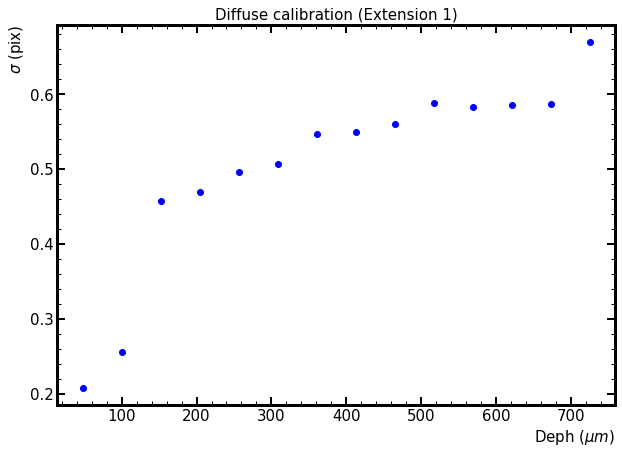

In [33]:
fig_2, axs_all_2 = plt.subplots(figsize = [10, 7])

axs_all_2.scatter(list_deep, list_sigmas[::-1], marker='o', color='b', label = 'Muon: 1')
# axs_all_2.scatter(list_all_deeps_2, list_all_sigmas_2, marker='v', color='r', label = 'Muon: 2')
# axs_all_2.scatter(list_all_deeps_3, list_all_sigmas_3, marker='^', color='g', label = 'Muon: 3')
# axs_all_2.scatter(list_all_deeps_4, list_all_sigmas_4, marker='<', color='m', label = 'Muon: 4')
# axs_all_2.scatter(list_all_deeps_5, list_all_sigmas_5, marker='>', color='orange', label = 'Muon: 5')


# axs_all_2.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
# axs_all_2.set_title('Diffuse calibration (Extension 2)', size = 15)#, y=0.92)}
axs_all_2.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
axs_all_2.set_ylabel(r'$\sigma$ (pix)')
axs_all_2.set_xlabel(r'Deph ($\mu m$)')
# axs_all_2.set_xlim(0, 725)
# axs_all_2.legend()
axs_all_2.grid

plt.show()
